In [137]:
"""Chapter 3. Statistial Experiments and Significance Testing."""

'Chapter 3. Statistial Experiments and Significance Testing.'

# Practical Statistics for Data Scientists (2nd edition)
# Chapter 3. Statistial Experiments and Significance Testing
> (c) 2020 Peter Bruce, Andrew Bruce, Peter Gedeck

Import required Python packages.

In [138]:
import random
from pathlib import Path
from typing import Sequence

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pandas import DataFrame, Series
from scipy import stats

%matplotlib inline

In [139]:
try:
    import common

    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / "data"

Define paths to data sets. If you don't keep your data in the same directory as the code, adapt the path names.

In [140]:
WEB_PAGE_DATA_CSV = DATA / "web_page_data.csv"
FOUR_SESSIONS_CSV = DATA / "four_sessions.csv"
CLICK_RATE_CSV = DATA / "click_rates.csv"
IMANISHI_CSV = DATA / "imanishi_data.csv"

# Resampling

In [141]:
session_times = pd.read_csv(WEB_PAGE_DATA_CSV)
session_times.Time = 100 * session_times.Time

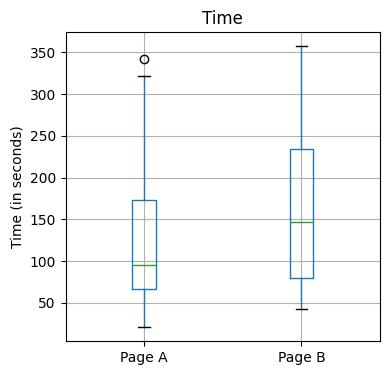

In [142]:
ax = session_times.boxplot(by="Page", column="Time", figsize=(4, 4))
ax.set_xlabel("")
ax.set_ylabel("Time (in seconds)")
plt.suptitle("")

plt.tight_layout()
plt.show()

In [143]:
mean_a = session_times[session_times.Page == "Page A"].Time.mean()
mean_b = session_times[session_times.Page == "Page B"].Time.mean()
print(mean_b - mean_a)

35.66666666666667


The following code is different to the R version. idx_A and idx_B are reversed.

In [144]:
def perm_fun(x_var: Series, n_a: int, n_b: int) -> float:  # type: ignore
    """Compute the difference in means between 2 random subsamples."""
    n_var = n_a + n_b
    idx_b = set(random.sample(range(n_var), n_b))
    idx_a = set(range(n_var)) - idx_b
    return x_var.loc[list(idx_b)].mean() - x_var.loc[list(idx_a)].mean()


a_smpl = session_times[session_times.Page == "Page A"].shape[0]
b_smpl = session_times[session_times.Page == "Page B"].shape[0]
print(perm_fun(session_times.Time, a_smpl, b_smpl))

35.09523809523809


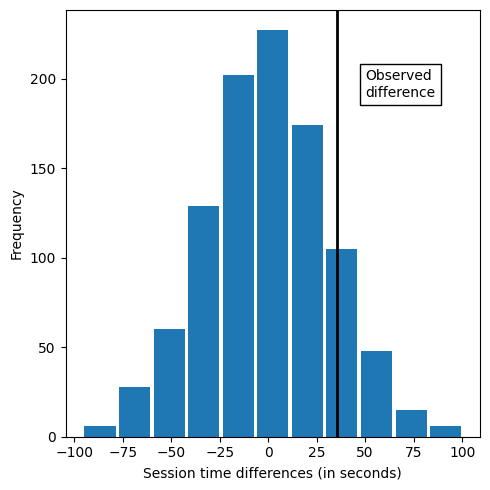

In [145]:
# fmt: off
random.seed(1)
perm_diffs = [
    perm_fun(session_times.Time, a_smpl, b_smpl) 
    for _ in range(1000)
]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=mean_b - mean_a, color="black", lw=2)
ax.text(50, 190, "Observed\ndifference", bbox={"facecolor": "white"})
ax.set_xlabel("Session time differences (in seconds)")
ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()
# fmt: on

In [146]:
# convert perm_diffs to numpy array to avoid problems with some Python installations
# perm_diffs = np.array(perm_diffs)
perm_diffs_2: np.ndarray = np.array([])
perm_diffs_2 = np.array(perm_diffs_2)
print(np.mean(perm_diffs_2 > mean_b - mean_a))

nan


c:\Users\Ruslan\miniconda3\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Ruslan\miniconda3\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


# Statistical Significance and P-Values

Observed difference: 0.0368%


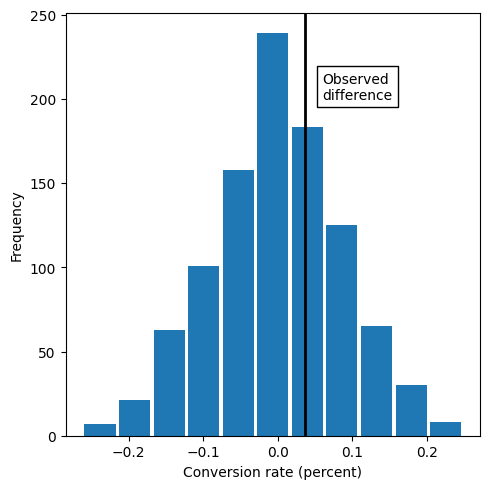

In [147]:
random.seed(1)
obs_pct_diff = 100 * (200 / 23739 - 182 / 22588)
print(f"Observed difference: {obs_pct_diff:.4f}%")
# conversion: Series[int] = [0] * 45945
# conversion.extend([1] * 382)
# conversion = pd.Series(conversion)
conversion: Series = pd.Series([0] * 45945 + [1] * 382)  # type: ignore

perm_diffs = [100 * perm_fun(conversion, 23739, 22588) for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=obs_pct_diff, color="black", lw=2)
ax.text(0.06, 200, "Observed\ndifference", bbox={"facecolor": "white"})
ax.set_xlabel("Conversion rate (percent)")
ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

## P-Value
If `np.mean` is applied to a list of booleans, it gives the percentage of how often True was found in the list (#True / #Total).

In [148]:
print(np.mean([diff > obs_pct_diff for diff in perm_diffs]))

0.332


In [149]:
survivors = np.array([[200, 23739 - 200], [182, 22588 - 182]])
chi2, p_value, df, _ = stats.chi2_contingency(survivors)

print(f"p-value for single sided test: {p_value / 2:.4f}")

p-value for single sided test: 0.3498


# t-Tests

In [150]:
res = stats.ttest_ind(
    session_times[session_times.Page == "Page A"].Time,
    session_times[session_times.Page == "Page B"].Time,
    equal_var=False,
)
print(f"p-value for single sided test: {res.pvalue / 2:.4f}")

p-value for single sided test: 0.1408


In [151]:
tstat, pvalue, df = sm.stats.ttest_ind(
    session_times[session_times.Page == "Page A"].Time,
    session_times[session_times.Page == "Page B"].Time,
    usevar="unequal",
    alternative="smaller",
)
print(f"p-value: {pvalue:.4f}")

p-value: 0.1408


# ANOVA

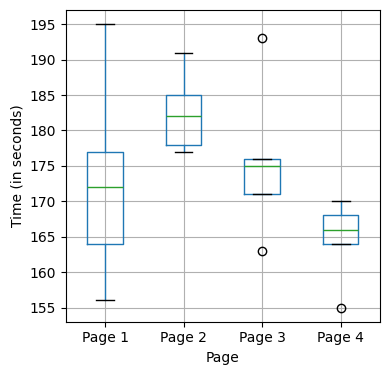

In [152]:
four_sessions = pd.read_csv(FOUR_SESSIONS_CSV)

ax = four_sessions.boxplot(by="Page", column="Time", figsize=(4, 4))
ax.set_xlabel("Page")
ax.set_ylabel("Time (in seconds)")
plt.suptitle("")
plt.title("")

plt.tight_layout()
plt.show()

In [153]:
print(pd.read_csv(FOUR_SESSIONS_CSV).head())

     Page  Time
0  Page 1   164
1  Page 2   178
2  Page 3   175
3  Page 4   155
4  Page 1   172


In [154]:
observed_variance = four_sessions.groupby("Page").mean().var().iloc[0]
print("Observed means:", four_sessions.groupby("Page").mean().values.ravel())
print("Variance:", observed_variance)
# Permutation test example with stickiness


def perm_test(df_: DataFrame) -> float:
    """Return perm example."""
    df_ = df_.copy()
    df_["Time"] = np.random.permutation(df_["Time"].values)
    return float(df_.groupby("Page").mean().var().iloc[0])


print(perm_test(four_sessions))

Observed means: [172.8 182.6 175.6 164.6]
Variance: 55.426666666666655
7.480000000000023


Pr(Prob) 0.08633333333333333


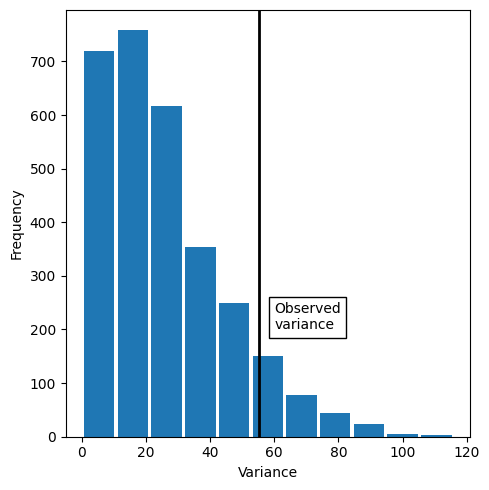

In [155]:
random.seed(1)
perm_variance = [perm_test(four_sessions) for _ in range(3000)]
print("Pr(Prob)", np.mean([var > observed_variance for var in perm_variance]))

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_variance, bins=11, rwidth=0.9)
ax.axvline(x=observed_variance, color="black", lw=2)
ax.text(60, 200, "Observed\nvariance", bbox={"facecolor": "white"})
ax.set_xlabel("Variance")
ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

## F-Statistic
We can compute an ANOVA table using statsmodel.

In [156]:
model = smf.ols("Time ~ Page", data=four_sessions).fit()

aov_table = sm.stats.anova_lm(model)
print(aov_table)

            df  sum_sq     mean_sq         F    PR(>F)
Page       3.0   831.4  277.133333  2.739825  0.077586
Residual  16.0  1618.4  101.150000       NaN       NaN


In [157]:
res = stats.f_oneway(
    four_sessions[four_sessions.Page == "Page 1"].Time,
    four_sessions[four_sessions.Page == "Page 2"].Time,
    four_sessions[four_sessions.Page == "Page 3"].Time,
    four_sessions[four_sessions.Page == "Page 4"].Time,
)
print(f"F-Statistic: {res.statistic / 2:.4f}")
print(f"p-value: {res.pvalue / 2:.4f}")

F-Statistic: 1.3699
p-value: 0.0388


### Two-way anova only available with statsmodels
```
formula = 'len ~ C(supp) + C(dose) + C(supp):C(dose)'
model = ols(formula, data).fit()
aov_table = anova_lm(model, typ=2)
```

# Chi-Square Test
## Chi-Square Test: A Resampling Approach

In [158]:
# Table 3-4
click_rate = pd.read_csv(CLICK_RATE_CSV)
clicks = click_rate.pivot(index="Click", columns="Headline", values="Rate")
print(clicks)

Headline  Headline A  Headline B  Headline C
Click                                       
Click             14           8          12
No-click         986         992         988


In [159]:
# Table 3-5
row_average = clicks.mean(axis=1)
pd.DataFrame(
    {
        "Headline A": row_average,
        "Headline B": row_average,
        "Headline C": row_average,
    }
)

,Headline A,Headline B,Headline C
Click,,,
Click,11.333333,11.333333,11.333333
No-click,988.666667,988.666667,988.666667


In [160]:
# fmt: off
# Resampling approach
box = [1] * 34
box.extend([0] * 2966)
random.shuffle(box)


def chi2_pm(observed: Sequence[Sequence[float]], expected_: Sequence[float]) -> float:
    """Compute chi-squared statistic from observed and expected counts."""
    pearson_residuals = []
    for row, expect in zip(observed, expected_):
        pearson_residuals.append(
            [(observe - expect) ** 2 / expect for observe in row]
        )
    # return sum of squares
    return np.sum(pearson_residuals)  # type: ignore


expected_clicks = 34 / 3
expected_noclicks = 1000 - expected_clicks
expected = [expected_clicks, expected_noclicks]
chi2observed = chi2_pm(clicks.values, expected)  # type: ignore


def perm_fun_2(box_: Series) -> float:  # type: ignore
    """Perform one permutation iteration for chi-squared test."""
    random.shuffle(box_)  # type: ignore
    sample_clicks = [
        sum(box_[0:1000]), 
        sum(box[1000:2000]), 
        sum(box_[2000:3000])
    ]
    sample_noclicks = [1000 - n for n in sample_clicks]
    return chi2_pm([sample_clicks, sample_noclicks], expected)


perm_chi2 = [perm_fun_2(box) for _ in range(2000)]  # type: ignore

resampled_p_value_1 = (
    sum(stat > chi2observed for stat in perm_chi2) / len(perm_chi2)
)
print(f"Observed chi2_pm: {chi2observed:.4f}")
print(f"Resampled p-value: {resampled_p_value_1:.4f}")
# fmt: on

Observed chi2_pm: 1.6659
Resampled p-value: 0.4660


In [161]:
chisq, pvalue, df, expected = stats.chi2_contingency(clicks)
print(f"Observed chi2: {chisq:.4f}")
print(f"p-value: {pvalue:.4f}")

Observed chi2: 1.6659
p-value: 0.4348


The above algorithm uses sampling into the three sets without replacement. Alternatively, it is also possible to sample with replacement.

In [162]:
# fmt: off
expected_2 = [expected_clicks, expected_noclicks]


def sample_with_replacement(box_2: list[int]) -> float:
    """Return sample with replacement."""
    sample_clicks = [
        sum(random.sample(box_2, 1000)),
        sum(random.sample(box_2, 1000)),
        sum(random.sample(box_2, 1000)),
    ]
    sample_noclicks = [1000 - n for n in sample_clicks]
    return float(chi2_pm([sample_clicks, sample_noclicks], expected_2))


perm_chi2 = [sample_with_replacement(box) for _ in range(2000)]

resampled_p_value_2: float = (
    sum(stat > chi2observed for stat in perm_chi2) / len(perm_chi2)
)
print(f"Observed chi2: {chi2observed:.4f}")
print(f"Resampled p-value: {resampled_p_value_2:.4f}")
# fmt: on

Observed chi2: 1.6659
Resampled p-value: 0.4845


## Figure chi-sq distribution

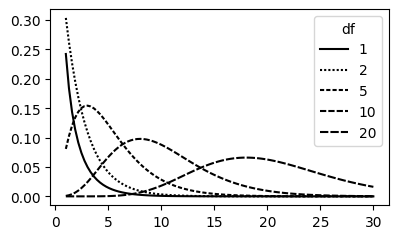

In [163]:
x_smpl = [1 + i * (30 - 1) / 99 for i in range(100)]

chi = pd.DataFrame(
    {
        "x_smpl": x_smpl,
        "chi_1": stats.chi2.pdf(x_smpl, df=1),
        "chi_2": stats.chi2.pdf(x_smpl, df=2),
        "chi_5": stats.chi2.pdf(x_smpl, df=5),
        "chi_10": stats.chi2.pdf(x_smpl, df=10),
        "chi_20": stats.chi2.pdf(x_smpl, df=20),
    }
)
fig, ax = plt.subplots(figsize=(4, 2.5))
ax.plot(chi.x_smpl, chi.chi_1, color="black", linestyle="-", label="1")
ax.plot(chi.x_smpl, chi.chi_2, color="black", linestyle=(0, (1, 1)), label="2")
ax.plot(chi.x_smpl, chi.chi_5, color="black", linestyle=(0, (2, 1)), label="5")
ax.plot(chi.x_smpl, chi.chi_10, color="black", linestyle=(0, (3, 1)), label="10")
ax.plot(chi.x_smpl, chi.chi_20, color="black", linestyle=(0, (4, 1)), label="20")
ax.legend(title="df")

plt.tight_layout()
plt.show()

## Fisher's Exact Test
Scipy has only an implementation of Fisher's Exact test for 2x2 matrices. There is a github repository that provides a Python implementation that uses the same code as the R version. Installing this requires a Fortran compiler. 
```
stats.fisher_exact(clicks)
```

# stats.fisher_exact(clicks.values)

### Scientific Fraud

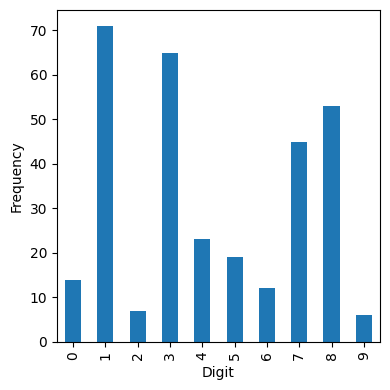

In [164]:
imanishi = pd.read_csv(IMANISHI_CSV)
imanishi.columns = [c.strip() for c in imanishi.columns]
ax = imanishi.plot.bar(x="Digit", y="Frequency", legend=False, figsize=(4, 4))
ax.set_xlabel("Digit")
ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# Power and Sample Size
statsmodels has a number of methods for power calculation

see e.g.: https://machinelearningmastery.com/statistical-power-and-power-analysis-in-python/

In [165]:
effect_size = sm.stats.proportion_effectsize(0.0121, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(
    effect_size=effect_size, alpha=0.05, power=0.8, alternative="larger"
)
print(f"Sample Size: {result:.3f}")

Sample Size: 116602.391


In [166]:
effect_size = sm.stats.proportion_effectsize(0.0165, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(
    effect_size=effect_size, alpha=0.05, power=0.8, alternative="larger"
)
print(f"Sample Size: {result:.3f}")

Sample Size: 5488.408
